# AML Homework 1

### Author: Yelene Cisse
### Date: 10/06/2025
### Updated: 11/04/2025
### Data: https://archive.ics.uci.edu/dataset/45/heart+disease
### Purpose:  

Predict whether a patient has heart disease based on medical attributes.

#### Runtime: < 1 minute

In [458]:
# Data Complete Dictionary from UCI website:

"""
age
sex: sex (1 = male; 0 = female)
cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
trestbps: resting blood pressure (in mm Hg on admission to the hospital)
chol: serum cholestoral in mg/dl
fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest 
-> Exercise-induced ST depression is a reliable sign of obstructive coronary artery disease, which means there are blockages in the heart's arteries (source: https://pmc.ncbi.nlm.nih.gov/articles/PMC1768611/)
slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
ca: number of major vessels (0-3) colored by flourosopy
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)
"""

"\nage\nsex: sex (1 = male; 0 = female)\ncp: chest pain type\n        -- Value 1: typical angina\n        -- Value 2: atypical angina\n        -- Value 3: non-anginal pain\n        -- Value 4: asymptomatic\ntrestbps: resting blood pressure (in mm Hg on admission to the hospital)\nchol: serum cholestoral in mg/dl\nfbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)\nrestecg: resting electrocardiographic results\n        -- Value 0: normal\n        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)\n        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria\nthalach: maximum heart rate achieved\nexang: exercise induced angina (1 = yes; 0 = no)\noldpeak = ST depression induced by exercise relative to rest \n-> Exercise-induced ST depression is a reliable sign of obstructive coronary artery disease, which means there are blockages in the heart's arteries (source: https://pmc.ncbi.nlm.ni

# Set up
Define useful functions.
Import necessary libraries and dataset.

In [459]:
# Import libraries

# For data manipulations
import pandas as pd
import numpy as np
import datetime

# For feature engineering
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# For model training
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_curve, auc, precision_recall_curve, roc_auc_score
)

# For visualization
from seaborn import heatmap
from matplotlib import pyplot as plt

# For export
import openpyxl
import xlsxwriter

# For data import:
from ucimlrepo import fetch_ucirepo
pd.set_option('display.max_columns', None)

In [460]:
# Define transformer class to do imputations
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy):
        """
        strategy: dict mapping column_name -> strategy
          - 'mean' → fill with mean (numeric only)
          - 'mode' → fill with mode (numeric or categorical)
          - any other value → used directly as fill value
        Example:
          {'age': 'mean', 'income': 'mode', 'gender': -1, 'city': 'Unknown'}
        """
        self.strategy = strategy
        self.fill_values_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col, strat in self.strategy.items():
            if strat == 'mean':
                self.fill_values_[col] = X[col].mean()
            elif strat == 'mode':
                self.fill_values_[col] = X[col].mode()[0]
            else:
                # fixed fill value (e.g., -1 or "Unknown")
                self.fill_values_[col] = strat
        return self

    def transform(self, X):
        X = X.copy()
        for col, fill_val in self.fill_values_.items():
            if col in X.columns:
                X[col] = X[col].fillna(fill_val)
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [461]:
# Define transformer class to do numerical groupings

class quantileGrouping(BaseEstimator, TransformerMixin):
    def __init__(self, method, closure, substring="_grouped"):
        self.method = method
        # closure determines if right-closed -> (a,b] or right-open [a,b) for bins
        self.closure = closure
        self.substring = substring
        self.groupings_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col, strat in self.method.items():
            if isinstance(strat, int):  # number of quantiles
                _, bins = pd.qcut(X[col], q=strat, retbins=True, duplicates='drop')
                self.groupings_[col] = bins
            elif isinstance(strat, list):  # custom bin edges
                self.groupings_[col] = strat
            else:
                raise ValueError("Method should be int (number of quantiles) or list (custom breaks)")
        return self

    def transform(self, X):
        X = X.copy()
        for col, bins in self.groupings_.items():
            if col in X.columns:
                X[col+self.substring] = pd.cut(X[col], bins=bins, right=self.closure, include_lowest=True)
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [462]:
# For data exploration
def data_summary(df, cat_cols, num_cols, describe_pts=[0.1, .2,.25,.5, .75, .9, .95, .99]):
    print("Data shape: ", df.shape)
    print("Data columns: ", df.columns)

    # Get hit rates for variables in the dataset, evaluate missing values proportions
    hr = df.notnull().mean().reset_index().rename(columns={'index':'variable',0:'hit_rate'}) 

    # Get data types
    df_types = df.dtypes.reset_index().rename(columns={'index':'variable',0:'data_type'}) 

    # Put info in same data add
    variable_summary = pd.merge(df_types, hr, on=['variable'], how='left', suffixes=('','_hr'))

    # Get value counts for categorical variables
    cat_vars_summary = pd.DataFrame(columns=['variable_name','unique_values','counts'])
    for col in cat_cols:
        new_counts = df[col].value_counts(dropna=False).rename_axis('unique_values').to_frame('counts').reset_index()
        new_counts.insert(loc=0, column='variable_name', value=col)
        cat_vars_summary = pd.concat([cat_vars_summary, new_counts], ignore_index = True)
        
    cont_vars_summary = df[num_cols].describe(describe_pts).reset_index().rename(columns={'index':'stats'}) 

    # Get correlation matrix for continuous variables
    df_corr = df[num_cols].corr()

    return variable_summary, cat_vars_summary, cont_vars_summary, df_corr


# For model evaluation - plotting confusion matrix with seaborn
def plot_confusion_matrix(cm, title, color="viridis",  annotation=True):
    fig, ax = plt.subplots()
    ax = heatmap(cm, annot=annotation, cmap=color)
    ax.set(xlabel="Predicted Value", ylabel="True Value")
    ax.set_title(title)
    return fig

def plot_roc_curve(y_true, y_pred, model_version=None):
    fpr, tpr, treshold = roc_curve(y_true, y_pred)
    area = roc_auc_score(y_true, y_pred)
    print("ROC AUC score: ", area)
    fig, ax = plt.subplots()
    plt.grid(color='grey', linestyle='--')
    plt.title('ROC curves: ' + model_version)
    plt.plot([0, 1], [0, 1], color='blue', label='Baseline')
    plt.plot([0, 0, 1], [0, 1, 1], color='green', label='Perfect ROC')
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend(['Baseline = 0.5', 'Perfect ROC = 1', 'ROC (area = ' + str(round(area,4))])
    plt.show()
    return fig


def plot_auc_curve(y_true, y_pred, cm, model_version=None):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    fpr, tpr, treshold = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    print("AUC: ", area)
    tn, fp, fn, tp = cm.ravel()
    baseline = (tp+fn)/(tn+fp+fn+tp) # baseline for auc = positive class / total
    fig, ax = plt.subplots()
    plt.grid(color='grey', linestyle='--')
    plt.title('Precision-Recall curve: ' + model_version)
    plt.plot([0, 1], [baseline, baseline], color='blue', label='Baseline AUC')
    plt.plot([1, 1, 0],[0, 1, 1], color='green', label='Perfect AUC')
    plt.plot(recall, precision, color='orange', label='AUC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(['Baseline = '+ str(round(baseline,4)), 'Perfect AUC = 1', 'ROC (area = ' + str(round(area,4))])
    plt.show()
    return fig


# The following function was taken from class Colab example, for verification of stratification
def pos_ratio(a):
    return float(a.mean())


In [463]:
# Set date and path for file saving
date = datetime.datetime.now().strftime("%m_%d_%Y")
folder_path = '/Users/yelene/Desktop/Grad school/Columbia/Classes/Fall 2025/AML/'
plot_path = folder_path + 'plots/'

# Set up EDA output
eda_filename = "AML_HW1_EDA_results_" + date + '.xlsx'
save_eda_results = False
eda_summary = {}

# Set up model output
version_run = "v3"
result_filename = "AML_HW1_model_results_" + version_run + "_" + date  + '.xlsx'
results_summary = {}


In [464]:
# Import dataset - Code directly taken from the source website

# fetch dataset 
heart_disease = fetch_ucirepo(id=45)

df = heart_disease.data.original
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

# Data Cleaning

In [465]:
# Create categorical and continuous lists
cat =  heart_disease.variables[heart_disease.variables['type']=="Categorical"]['name'].to_list()

# Based on variable dictionary, create different lists for binary and non binary variables
# We will use this distinction later for encoding
binary_cat = ['sex','fbs', 'exang']
non_binary_cat = [i for i in cat if i not in binary_cat]

cont =  heart_disease.variables[heart_disease.variables['type']=="Integer"]['name'].to_list()

print("Categorical features: " , cat, "\nContinuous features: ", cont)

Categorical features:  ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'] 
Continuous features:  ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'num']


Data exploration

In [466]:
# Get summary statistics
variable_summary, cat_vars_summary, cont_vars_summary, df_corr = data_summary(df, cat, cont)

Data shape:  (303, 14)
Data columns:  Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [467]:
variable_summary

# Hit rates are high within this dataset, only two variables with missing values, with less than 2% of the data missing.

,variable,data_type,hit_rate
0,age,int64,1.000000
1,sex,int64,1.000000
2,cp,int64,1.000000
3,trestbps,int64,1.000000
4,chol,int64,1.000000
5,fbs,int64,1.000000
6,restecg,int64,1.000000
7,thalach,int64,1.000000
8,exang,int64,1.000000
9,oldpeak,float64,1.000000


In [468]:
cat_vars_summary

# There is a good distribution of values among categories ( no variable dominated >95% + by one value), can keep all of them.

,variable_name,unique_values,counts
0,sex,1,206
1,sex,0,97
2,cp,4,144
3,cp,3,86
4,cp,2,50
5,cp,1,23
6,fbs,0,258
7,fbs,1,45
8,restecg,0,151
9,restecg,2,148


In [469]:
cont_vars_summary

# Looking at the 10th and 90th percentile, there does not seem to be major outliers in most variables.
# However, we will visualize the data before making any decision.

,stats,age,trestbps,chol,thalach,oldpeak,ca,num
0,count,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000
1,mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.672241,0.937294
2,std,9.038662,17.599748,51.776918,22.875003,1.161075,0.937438,1.228536
3,min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
4,10%,42.000000,110.000000,188.800000,116.000000,0.000000,0.000000,0.000000
5,20%,45.000000,120.000000,204.000000,130.000000,0.000000,0.000000,0.000000
6,25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
7,50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,0.000000
8,75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,2.000000
9,90%,66.000000,152.000000,308.800000,176.600000,2.800000,2.000000,3.000000


In [470]:
df_corr

# Variables with most correlation to target are ca, oldpeak and thalach
# Variables in general not closely correlated, all can be added to model.

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.362605,0.222853
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.098773,0.157754
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.119000,0.070909
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.264246,-0.415040
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.295832,0.504092
ca,0.362605,0.098773,0.119000,-0.264246,0.295832,1.000000,0.518909
num,0.222853,0.157754,0.070909,-0.415040,0.504092,0.518909,1.000000


In [471]:
# For saving EDA results
eda_summary['variable_summary'] = variable_summary
eda_summary['cat_vars_summary'] = cat_vars_summary
eda_summary['cont_vars_summary'] = cont_vars_summary
eda_summary['correlation_matrix'] = df_corr

Visualize data before cleaning/transformations

In [472]:
ditributions_dict = {}

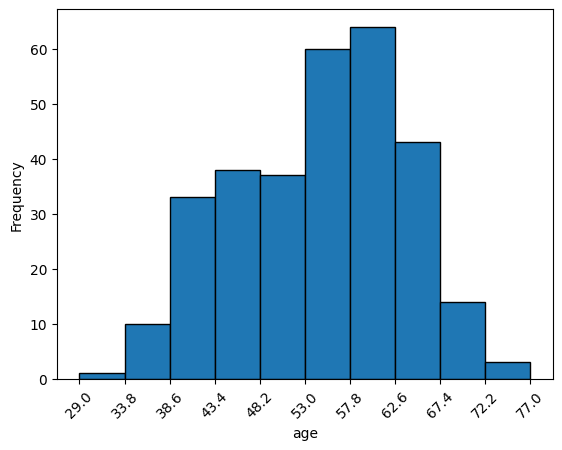

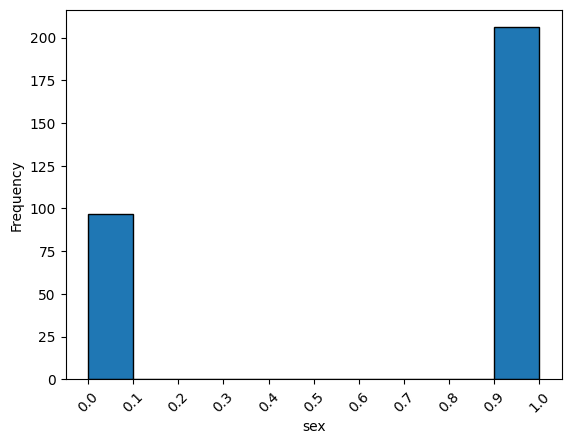

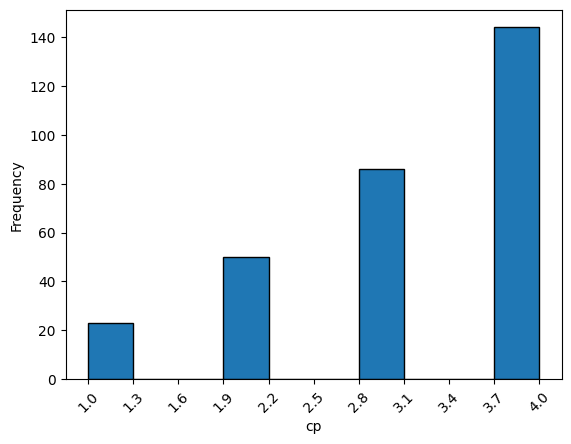

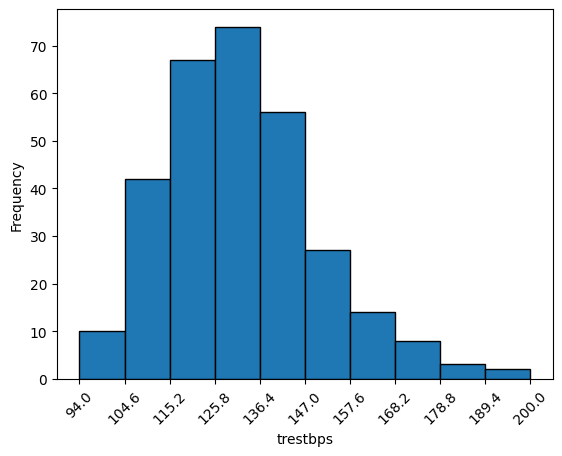

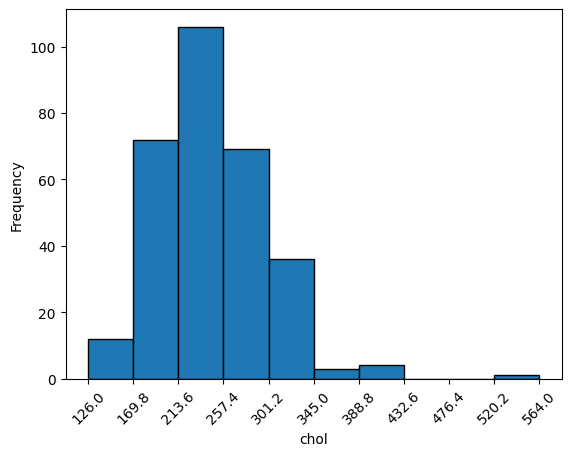

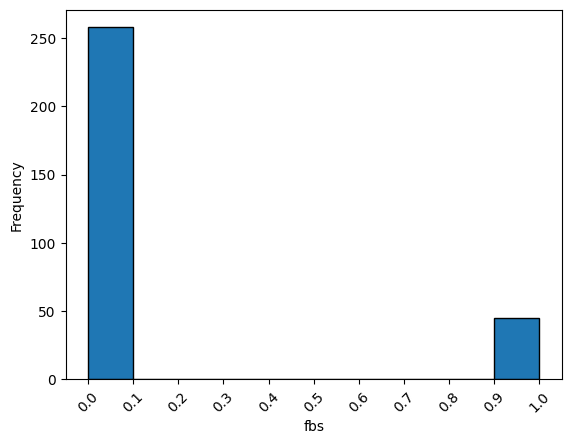

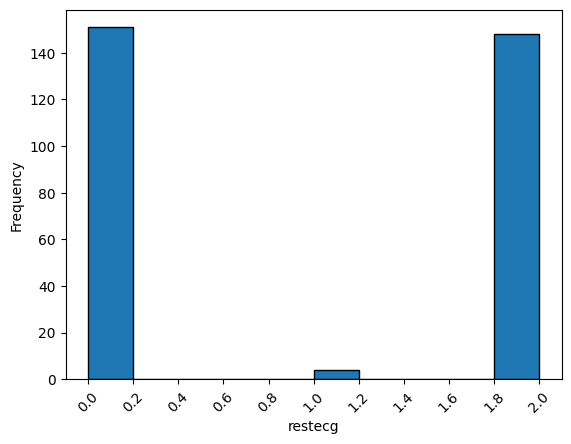

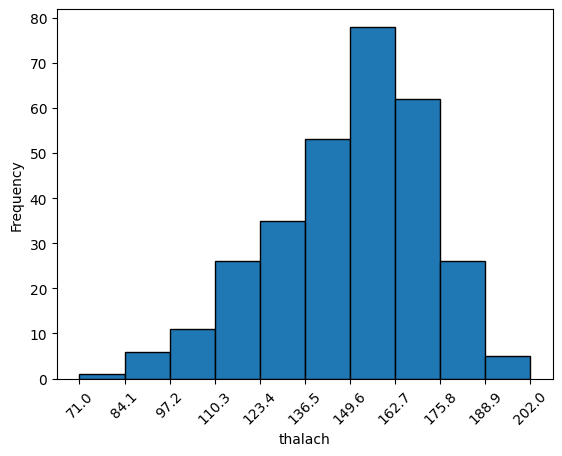

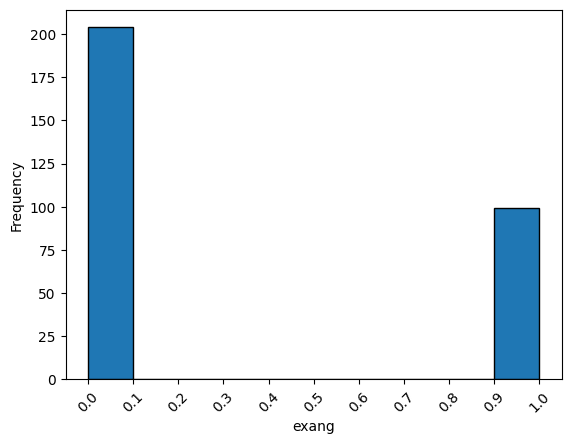

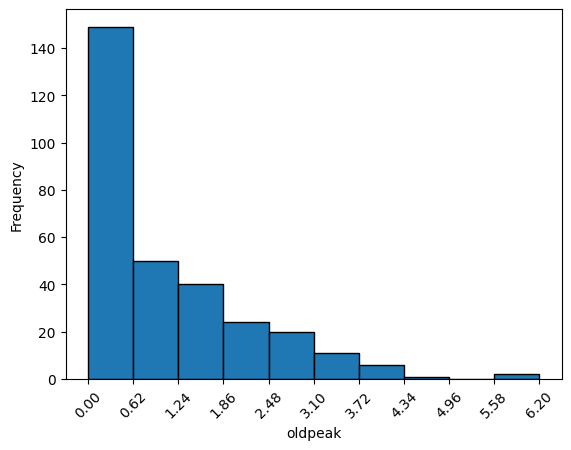

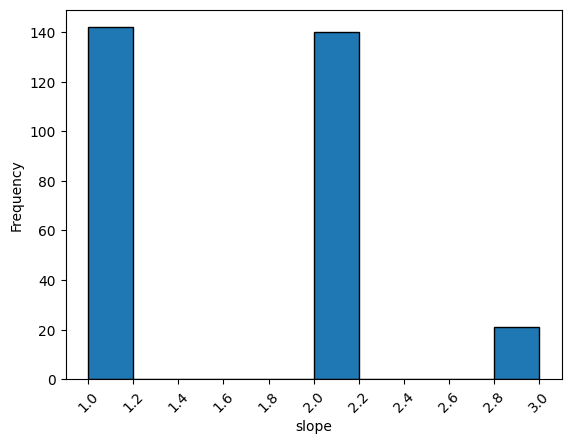

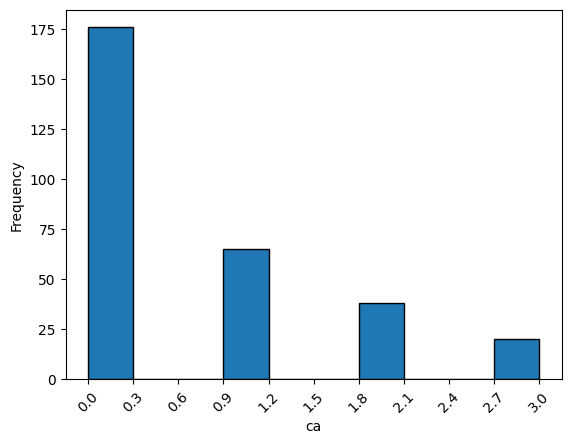

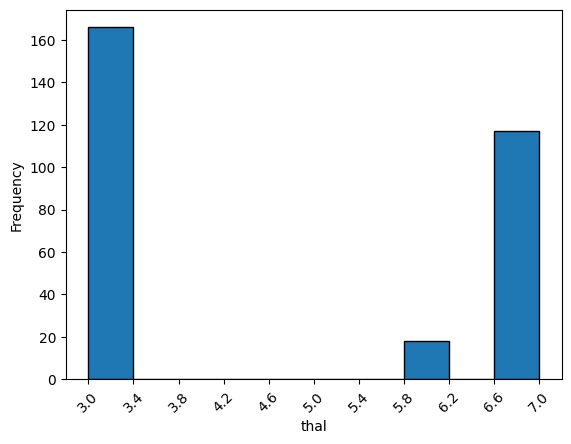

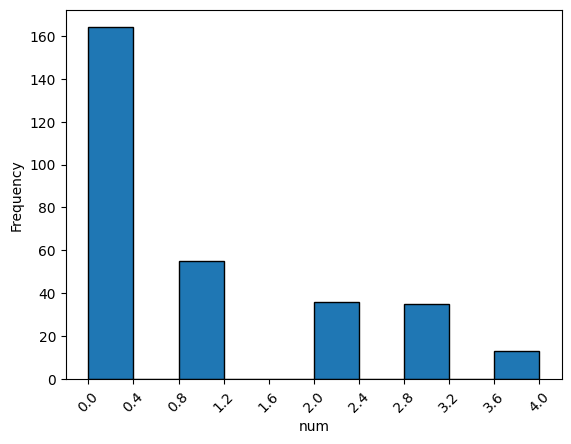

In [473]:
for var in df.columns:
    fig, ax = plt.subplots()
    counts, bin_edges, _ = plt.hist(df[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.fill()
    plt.show()
    ditributions_dict[var] = fig


Save Data Exploration results

In [474]:
if save_eda_results:
    with pd.ExcelWriter(folder_path+eda_filename) as writer:
        for sheet_name, eda_df in eda_summary.items():
            eda_df.to_excel(writer, sheet_name = sheet_name)

        workbook = writer.book
        worksheet = workbook.add_worksheet('histo_bar_plots')

        row = 0

        # Add confusion matrices
        for plot_name, fig in ditributions_dict.items():
            # Set the figure size
            fig.set_size_inches(8, 6)
            # Save the figure to a temporary file
            img_path = plot_path + plot_name + '.png'
            fig.savefig(img_path, bbox_inches='tight')
            # Insert the image into the worksheet
            worksheet.insert_image(row, 1, img_path)
            row += 30
            plt.close(fig)  # Close the figure to free memory

    writer.close()

# Feature engineering

We will start with arbitrary-based feature creation for categorical variables. Since these groupings are knowledge-based, we are safe to apply them on the full dataset.

We will do data-driven transformations on train dataset only, applying them to the test data later.

In [475]:
# Blood pressure categories
# Normal blood pressure is less than 120/80 mm Hg ; High blood pressure is consistently at or above 130/80 mm Hg (Source: CDC, https://www.cdc.gov/high-blood-pressure/about/index.html)
# We will let 0 = normal bp and 1 = high bp
df['trestbps_category'] = np.where(df['trestbps']>130, 1, 0)

# Add this to binary feature list
binary_cat.append('trestbps_category')

# Categorize age following Chronological age :
# Adulthood is usually divided into several periods: young or early adulthood (approximately aged 20–39), middle adulthood (40–59), and old age (60+). 
# Old age is typically divided into the periods of young old (60–75) and old old (75 and up). (Source: https://www.sciencedirect.com/topics/computer-science/chronological-age)
df['age_category'] = 'Young adulthood'
df.loc[df['age']>=40, 'age_category'] = 'Middle adulthood'
df.loc[df['age']>=60, 'age_category'] = 'Young old age'
df.loc[df['age']>=75, 'age_category'] = 'Old old age'

print(df['age_category'].value_counts())

# Cholesterol level grouping according to John Hopkins - (Source: https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/lipid-panel#:~:text=Normal:%20Less%20than%20150%20mg,14%20hours%20before%20this%20test.)
# Given limited information on cholesterol type, we will assume total cholesterol ranges for this exercise.
# Normal: Less than 200 mg/dL
# Borderline high: 200 to 239 mg/dL
# High: At or above 240 mg/dL

df['chol_category'] = 'Normal'
df.loc[df['chol']>=200, 'chol_category'] = 'Borderline high'
df.loc[df['chol']>=240, 'chol_category'] = 'High'

print(df['chol_category'].value_counts())

# Create a missing indicator for continuous variable
df['ca_miss_ind'] = np.where(df['ca'].isna(), 1, 0)

# Update categorical lists with new features

cat = cat + ['age_category', 'chol_category', 'oldpeak_category', 'thalach_category']
non_binary_cat = non_binary_cat + ['age_category', 'chol_category', 'oldpeak_category', 'thalach_category']


age_category
Middle adulthood    197
Young old age        89
Young adulthood      15
Old old age           2
Name: count, dtype: int64
chol_category
High               156
Borderline high     98
Normal              49
Name: count, dtype: int64


In [476]:
# Change target to binary, we are only interested in whether the heart didease is present or not.
# "Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0)"
print(df['num'].value_counts())
df['num'] = np.where(df['num']>0, 1, 0 )
print(df['num'].value_counts())

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
num
0    164
1    139
Name: count, dtype: int64


#### Data Split

In [477]:
# Split the data into training, test and validation
# We wil do an 70 - 30 split

# Select all items but target
X = df[[i for i in df.columns if i!='num']].copy()
# Create target df
y = df[['num']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)

for data in [X_train, X_test, y_train, y_test ]:
    print('Data shape: ', data.shape)
    # Reset index for standardization merge
    data.reset_index(inplace=True)
    data.drop('index', axis = 1,  inplace=True)



Data shape:  (212, 17)
Data shape:  (91, 17)
Data shape:  (212, 1)
Data shape:  (91, 1)


/var/folders/3g/b4zyzzk94gz7cbv03g735r2m0000gn/T/ipykernel_44888/2050364062.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(a.mean())


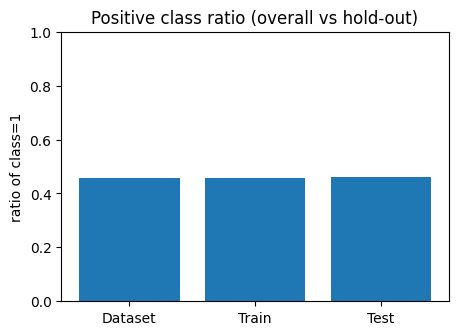

Overall: 0.459 | Train: 0.458 | Test: 0.462


In [478]:
# Make sure we get same ratio with stratified data
labels = ['Dataset', 'Train', 'Test']
ratios = [pos_ratio(y), pos_ratio(y_train), pos_ratio(y_test)]

plt.figure(figsize=(5,3.5))
plt.bar(labels, ratios)
plt.ylim(0,1)
plt.title('Positive class ratio (overall vs hold-out)')
plt.ylabel('ratio of class=1')
plt.show()

print(f'Overall: {pos_ratio(y):.3f} | Train: {pos_ratio(y_train):.3f} | Test: {pos_ratio(y_test):.3f}')


In [479]:
# Create copies before transformations
X_train_og = X_train.copy()
X_test_og =  X_test.copy()

Missing variables handling

In [480]:
# Check columns with missing value
df[df['ca'].isna()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,trestbps_category,age_category,chol_category,ca_miss_ind
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0,1,Middle adulthood,Borderline high,1
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1,1,Middle adulthood,High,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0,0,Middle adulthood,Borderline high,1
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0,1,Young adulthood,Normal,1


In [481]:
df[df['thal'].isna()]
# Since thal is amongst the categorical variables, we will fill with -1
# instead of dropping to avoid loss of information in other columns

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,trestbps_category,age_category,chol_category,ca_miss_ind
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0,0,Middle adulthood,Borderline high,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,1,0,Middle adulthood,Borderline high,0


In [482]:
# Mean/median/mode impute ca as this is a numerical variable
print('Mode: ', X_train['ca'].mode(), '\nMedian: ', X_train['ca'].median(), '\nDescribe: ', X_train['ca'].describe())

# Mean here is driven by upper 25% of the data, we will use the median and mode which is 0, as imputation value.

Mode:  0    0.0
Name: ca, dtype: float64 
Median:  0.0 
Describe:  count    209.000000
mean       0.626794
std        0.906414
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ca, dtype: float64


In [483]:
# Set up dict for missing transformations
miss_dict = {'ca':'mode', 'thal':-1}

# Initialize the imputer
imputer = MissingValueImputer(strategy=miss_dict)

# Fit on training data only
X_train = imputer.fit_transform(X_train)

# Transform test data
X_test = imputer.transform(X_test)

# Check
print(imputer.fill_values_)

{'ca': 0.0, 'thal': -1}


In [484]:
# After looking at the plots, cholesterol seem to have outlier > 500 and oldpeak outlier > 5

# check values
print(df[df['chol']>500]['chol'] , "\n" , df[df['oldpeak']>5]['oldpeak'])

152    564
Name: chol, dtype: int64 
 91     6.2
123    5.6
Name: oldpeak, dtype: float64


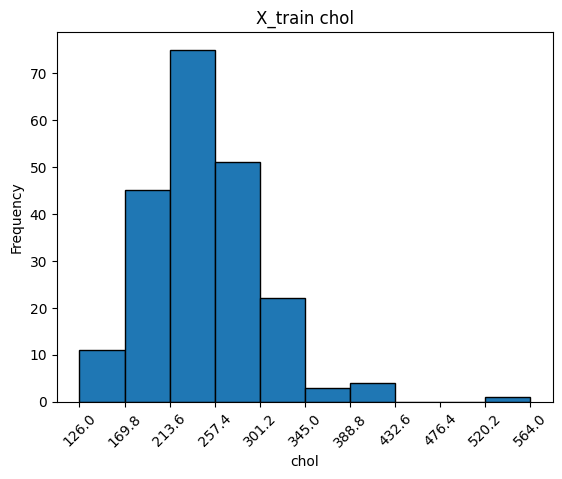

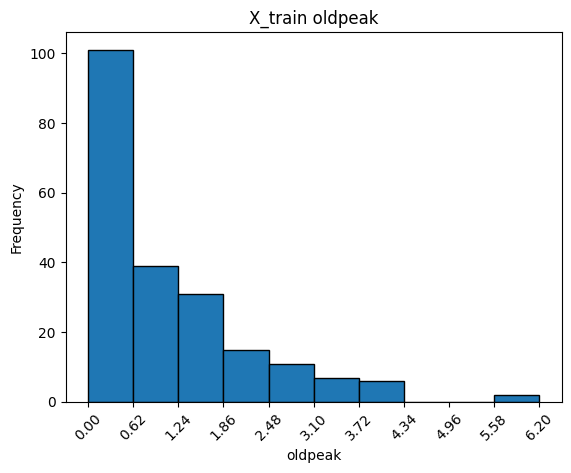

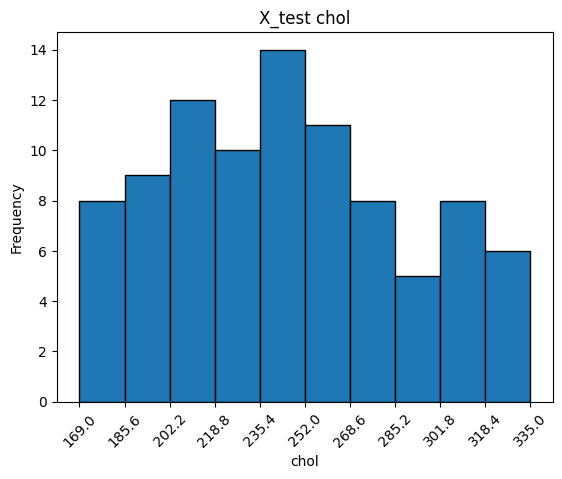

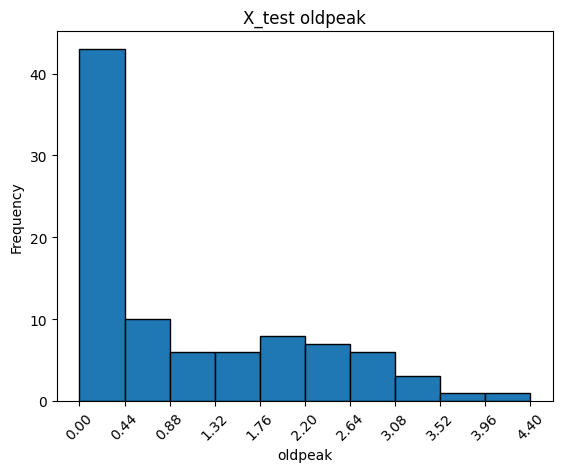

In [485]:
# Check distributions on train test split data
for var in ['chol','oldpeak']:
    counts, bin_edges, _ = plt.hist(X_train[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('X_train '+var)
    plt.fill()
    plt.show()

for var in ['chol','oldpeak']:
    counts, bin_edges, _ = plt.hist(X_test[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('X_test '+var)
    plt.fill()
    plt.show()
# We will use winsorizing method to cap outliers

In [486]:
# We will cap these variables to avoid disturbance in the models
# Use winsorize with interquartile range * 1.5 method for outliers
winsor = Winsorizer(
    capping_method='iqr',   
    tail='right',
    fold=1.5,
    variables=['chol', 'oldpeak']
)

X_train = winsor.fit_transform(X_train)
X_test = winsor.transform(X_test)

# df.loc[df['chol']>500, 'chol'] = df[df['chol']<500]['chol'].max()
# df.loc[df['oldpeak']>5, 'oldpeak'] = df[df['oldpeak']<5]['oldpeak'].max()

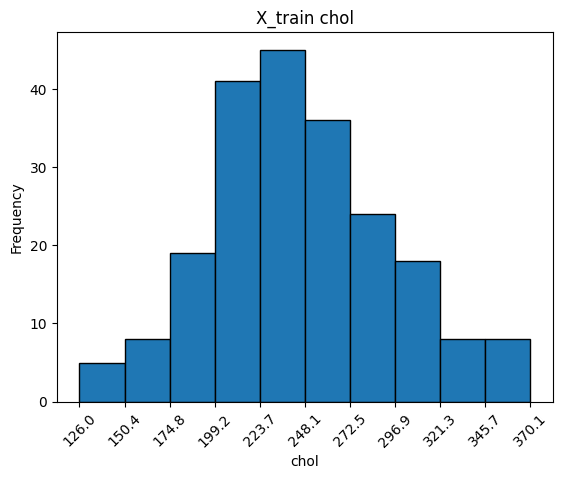

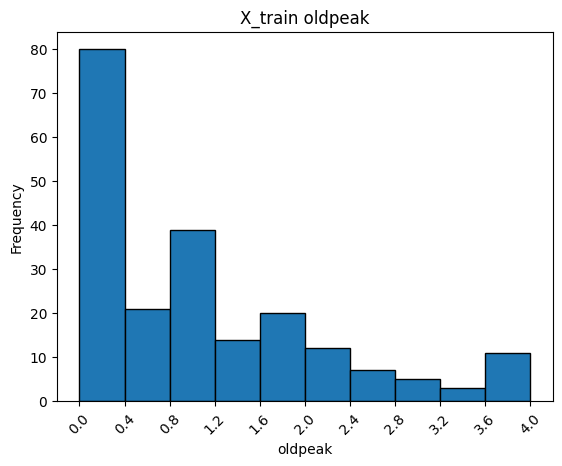

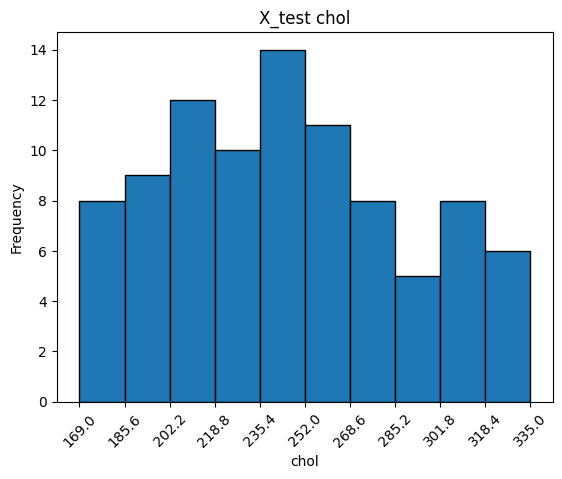

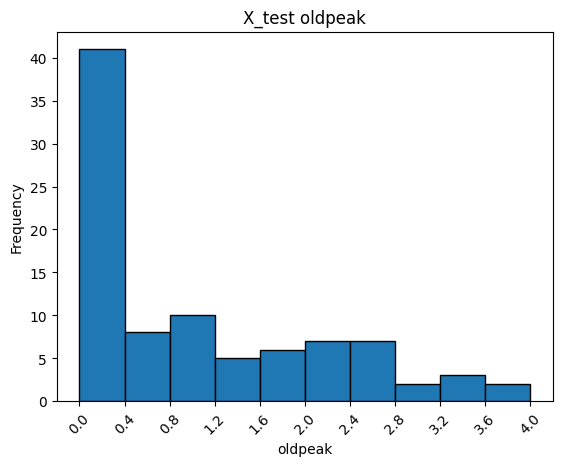

In [487]:
# Verify changes
for var in ['chol','oldpeak']:
    counts, bin_edges, _ = plt.hist(X_train[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('X_train '+var)
    plt.fill()
    plt.show()

for var in ['chol','oldpeak']:
    counts, bin_edges, _ = plt.hist(X_test[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('X_test '+var)
    plt.fill()
    plt.show()
# chol could be grouped further but we will keep this level of granularity to avoid information loss

In [488]:
# We will use binning transformer for oldpeak and thalach.
# Since oldpeak is 50% 0s, we will start at .5 and increment by 10% to create 5 bins
# Create deciles for thalach
# df['oldpeak_category'] = pd.qcut(df['oldpeak'], q =[0, .5, .6, .7, .8, .9, 1])
# df['thalach_category'] = pd.qcut(df['thalach'], q =10)

method_dict = {'oldpeak':[0, .5, .6, .7, .8, .9, 1], 'thalach':10}
group_transformer = quantileGrouping(method_dict, closure=False, substring="_category")

X_train = group_transformer.fit_transform(X_train)
X_test = group_transformer.transform(X_test)

print(X_train['oldpeak_category'].value_counts(), X_train['thalach_category'].value_counts())

cat = cat + [ 'oldpeak_category', 'thalach_category']
non_binary_cat = non_binary_cat + ['oldpeak_category', 'thalach_category']

oldpeak_category
[0.0, 0.5)    87
[0.6, 0.7)    10
[0.8, 0.9)     9
[0.5, 0.6)     4
[0.9, 1.0)     3
[0.7, 0.8)     0
Name: count, dtype: int64 thalach_category
[154.0, 159.6)    24
[126.0, 142.0)    23
[169.0, 174.0)    23
[174.0, 202.0)    23
[142.0, 146.4)    22
[163.0, 169.0)    22
[71.0, 115.0)     21
[115.0, 126.0)    19
[146.4, 154.0)    18
[159.6, 163.0)    16
Name: count, dtype: int64


One hot-encoding

In [489]:
# Bernoulli Transformations

# One hot-encoding on categorical variables
encoded_var_list = []

# The code below is adapted from the "AML_L2_Colab_Demos.ipynb" code example
for var in non_binary_cat:
    print('Variable to encode: ', var)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    var_ohe = ohe.fit_transform(X_train[[var]])
    var_ohe_test = ohe.transform(X_test[[var]])

    print("One-hot categories:", ohe.categories_)
    print("Encoded shape:", var_ohe.shape)

    encoded_var_train = pd.DataFrame(var_ohe, columns=[f"{var}={c}" for c in ohe.categories_[0]])
    encoded_var_test = pd.DataFrame(var_ohe_test, columns=[f"{var}={c}" for c in ohe.categories_[0]])

    encoded_var_list = encoded_var_list + list(encoded_var_train.columns)

    X_train = pd.merge(X_train, encoded_var_train, left_index=True, right_index=True, how='left', suffixes=('','_encod_var'))
    X_test = pd.merge(X_test, encoded_var_test, left_index=True, right_index=True, how='left', suffixes=('','_encod_var'))
    
    print(X_train.shape, X_test.shape)

Variable to encode:  cp
One-hot categories: [array([1, 2, 3, 4])]
Encoded shape: (212, 4)
(212, 23) (91, 23)
Variable to encode:  restecg
One-hot categories: [array([0, 1, 2])]
Encoded shape: (212, 3)
(212, 26) (91, 26)
Variable to encode:  slope
One-hot categories: [array([1, 2, 3])]
Encoded shape: (212, 3)
(212, 29) (91, 29)
Variable to encode:  thal
One-hot categories: [array([-1.,  3.,  6.,  7.])]
Encoded shape: (212, 4)
(212, 33) (91, 33)
Variable to encode:  age_category
One-hot categories: [array(['Middle adulthood', 'Young adulthood', 'Young old age'],
      dtype=object)]
Encoded shape: (212, 3)
(212, 36) (91, 36)
Variable to encode:  chol_category
One-hot categories: [array(['Borderline high', 'High', 'Normal'], dtype=object)]
Encoded shape: (212, 3)
(212, 39) (91, 39)
Variable to encode:  oldpeak_category
One-hot categories: [array([Interval(0.0, 0.5, closed='left'),
       Interval(0.5, 0.6, closed='left'),
       Interval(0.6, 0.7, closed='left'),
       Interval(0.8, 0.9,

Standardization

In [490]:
# Standardize continuous data for model

# Get continuous list without target
model_cont = [i for i in cont if 'num' not in i]
# The code below is adapted from the "AML_L2_Colab_Demos.ipynb" example
scaler = StandardScaler()
std = scaler.fit_transform(X_train[model_cont])
std_test = scaler.transform(X_test[model_cont])

standardized_df = pd.DataFrame(std, columns=model_cont)
standardized_df_test = pd.DataFrame(std_test, columns=model_cont)

# Rename axis before merging normalized variables with data
rename_dict = dict(zip(model_cont, [i+"_std" for i in model_cont]))

standardized_df.rename(columns=rename_dict, inplace=True)
standardized_df_test.rename(columns=rename_dict, inplace=True)

# Check
print(standardized_df, standardized_df_test)

# Add standardize variables to the data
X_train = pd.merge(X_train, standardized_df, left_index=True, right_index=True, how='left', suffixes=('','_std_var'))
X_test = pd.merge(X_test, standardized_df_test, left_index=True, right_index=True, how='left', suffixes=('','_std_var'))
print(X_train.shape, X_test.shape)

X_train.head()

      age_std  trestbps_std  chol_std  thalach_std  oldpeak_std    ca_std
0   -0.409140     -1.755970 -0.485687    -0.278951     0.155178 -0.685920
1   -0.289004      0.132857 -0.912541     0.374263    -0.208332  0.424119
2    1.873429      1.577254  0.469651    -1.628927     1.700094  0.424119
3   -1.730626     -1.200432 -1.603636    -1.541832     0.882197 -0.685920
4    0.551942      2.355007  0.063124    -0.278951    -0.935352 -0.685920
..        ...           ...       ...          ...          ...       ...
207  1.272753      0.355072  0.733894     1.071025     0.336932  0.424119
208 -1.250086     -0.089358 -0.262097     1.288763    -0.571842 -0.685920
209 -0.289004      0.355072 -0.465361     0.853287    -0.935352 -0.685920
210 -1.610491      0.188411 -0.871888    -0.757975    -0.935352 -0.685920
211 -1.129951     -0.200465  1.262379     0.896834    -0.935352 -0.685920

[212 rows x 6 columns]      age_std  trestbps_std  chol_std  thalach_std  oldpeak_std    ca_std
0  -1.009815   

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,trestbps_category,age_category,chol_category,ca_miss_ind,oldpeak_category,thalach_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan,"oldpeak_category=[0.0, 0.5)_encod_var","oldpeak_category=[0.5, 0.6)_encod_var","oldpeak_category=[0.6, 0.7)_encod_var","oldpeak_category=[0.8, 0.9)_encod_var","oldpeak_category=[0.9, 1.0)_encod_var",oldpeak_category=nan_encod_var,"thalach_category=[71.0, 115.0)_encod_var","thalach_category=[115.0, 126.0)_encod_var","thalach_category=[126.0, 142.0)_encod_var","thalach_category=[142.0, 146.4)_encod_var","thalach_category=[146.4, 154.0)_encod_var","thalach_category=[154.0, 159.6)_encod_var","thalach_category=[159.6, 163.0)_encod_var","thalach_category=[163.0, 169.0)_encod_var","thalach_category=[169.0, 174.0)_encod_var","thalach_category=[174.0, 202.0)_encod_var",thalach_category=nan_encod_var,age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std
0,51,1,3,100,222.0,0,0,143,1,1.2,2,0.0,3.0,0,Middle adulthood,Borderline high,0,NaN,"[142.0, 146.4)",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.409140,-1.755970,-0.485687,-0.278951,0.155178,-0.685920
1,52,1,2,134,201.0,0,0,158,0,0.8,1,1.0,3.0,1,Middle adulthood,Borderline high,0,"[0.8, 0.9)","[154.0, 159.6)",0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.289004,0.132857,-0.912541,0.374263,-0.208332,0.424119
2,70,1,3,160,269.0,0,0,112,1,2.9,2,1.0,7.0,1,Young old age,High,0,NaN,"[71.0, 115.0)",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873429,1.577254,0.469651,-1.628927,1.700094,0.424119
3,40,1,4,110,167.0,0,2,114,1,2.0,2,0.0,7.0,0,Middle adulthood,Normal,0,NaN,"[71.0, 115.0)",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.730626,-1.200432,-1.603636,-1.541832,0.882197,-0.685920
4,59,0,4,174,249.0,0,0,143,1,0.0,2,0.0,3.0,1,Middle adulthood,High,0,"[0.0, 0.5)","[142.0, 146.4)",0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.551942,2.355007,0.063124,-0.278951,-0.935352,-0.685920


In [491]:
# Keep a copy of the full data - could save for future model runs and monitoring.
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

In [492]:
X_train = X_train_fe.copy()
X_test = X_test_fe.copy()

# Model Training

In [493]:
# Set up parameters for model runs

# Laplace smoothing parameters
alphasNB = {'alpha = 1':1, 'alpha = 0.01':0.01, 'alpha = 0.05':0.05, 'alpha = 0.00001':0.00001}

# Regression: Lasso - shrink coefficients to 0 ; Ridge - shrink coefficients equally
alphasLR = { 'Regular LR':"n/a", 'Lasso':0, 'Ridge':1}

# Change y to nd array for model - warning when running without
y_train, y_test = np.array(y_train['num']), np.array(y_test['num'])

In [494]:
# Set up dataframes and dict to capture results
models_accuracy_scores = pd.DataFrame(columns=['model','alpha','accuracy'])
metrics_totals_summary = None
metrics_by_target_level_summary = None
area_under_curves = pd.DataFrame(columns=['model','alpha','roc/auc'])

# Create a table for error metrics - for Linear Regression
error_metrics = pd.DataFrame(columns=['model','MSE','MAE', 'R2'])
coeff_table_summary = None

# Dictionary to capture plots for review
plot_dict = {}
# Set counter for each plot
plot_count = 1

## a. Naive Bayes

We will test two models: BernoulliNB for categorical features and GaussianNB for continuous only.

We will also test all features with each model ( with appropriate tranformations ) and evaluate the best one, then we will do a comparison with the linear regression model.

### Run BernoulliNB

In [495]:
# Create the BernoulliNB X datasets with categorical vars

included_vars = binary_cat + encoded_var_list

# To update after reviewing results
# First we will test categorical variables that were already in the dataset
# Then we will add variables derived from continuous
# exclude_vars = [i for i in included_vars if '_category' in i]
exclude_vars = []

X_train_bernNB = X_train[[i for i in included_vars if i not in exclude_vars]] 
X_test_bernNB = X_test[[i for i in included_vars if i not in exclude_vars]] 

print(X_train_bernNB.columns, X_train_bernNB.shape)
X_train_bernNB.head()

Index(['sex', 'fbs', 'exang', 'trestbps_category', 'cp=1', 'cp=2', 'cp=3',
       'cp=4', 'restecg=0', 'restecg=1', 'restecg=2', 'slope=1', 'slope=2',
       'slope=3', 'thal=-1.0', 'thal=3.0', 'thal=6.0', 'thal=7.0',
       'age_category=Middle adulthood', 'age_category=Young adulthood',
       'age_category=Young old age', 'chol_category=Borderline high',
       'chol_category=High', 'chol_category=Normal',
       'oldpeak_category=[0.0, 0.5)', 'oldpeak_category=[0.5, 0.6)',
       'oldpeak_category=[0.6, 0.7)', 'oldpeak_category=[0.8, 0.9)',
       'oldpeak_category=[0.9, 1.0)', 'oldpeak_category=nan',
       'thalach_category=[71.0, 115.0)', 'thalach_category=[115.0, 126.0)',
       'thalach_category=[126.0, 142.0)', 'thalach_category=[142.0, 146.4)',
       'thalach_category=[146.4, 154.0)', 'thalach_category=[154.0, 159.6)',
       'thalach_category=[159.6, 163.0)', 'thalach_category=[163.0, 169.0)',
       'thalach_category=[169.0, 174.0)', 'thalach_category=[174.0, 202.0)',
   

,sex,fbs,exang,trestbps_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan
0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is the alpha = 1 run.
Getting metrics...
ROC AUC score:  0.8112244897959184


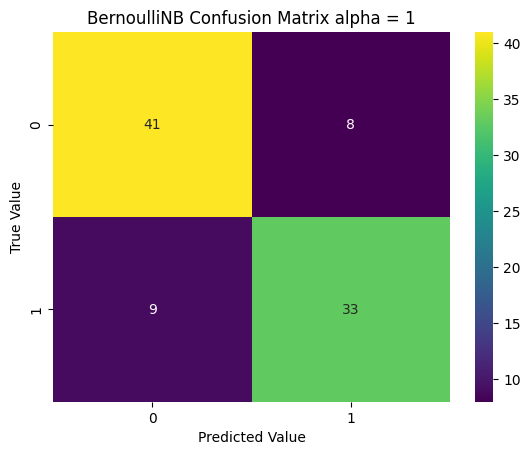

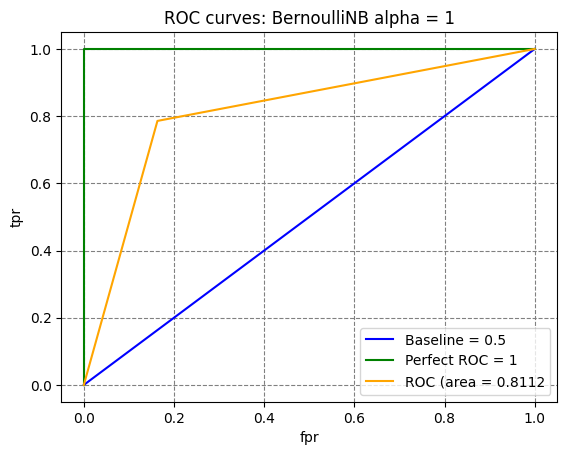

AUC:  0.8112244897959184


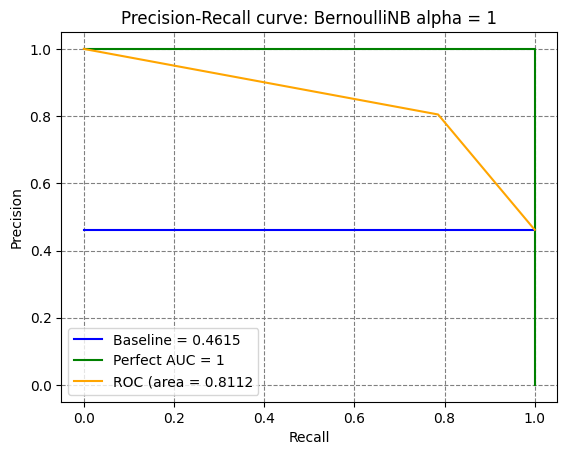

This is the alpha = 0.01 run.
Getting metrics...
ROC AUC score:  0.7874149659863946


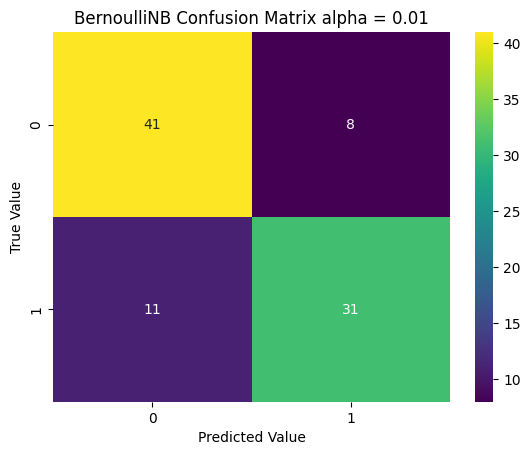

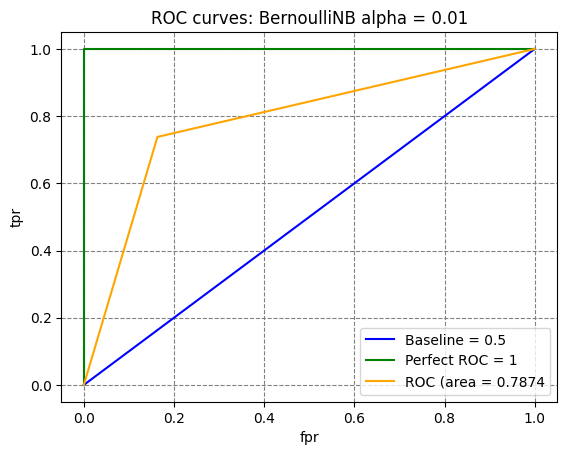

AUC:  0.7874149659863946


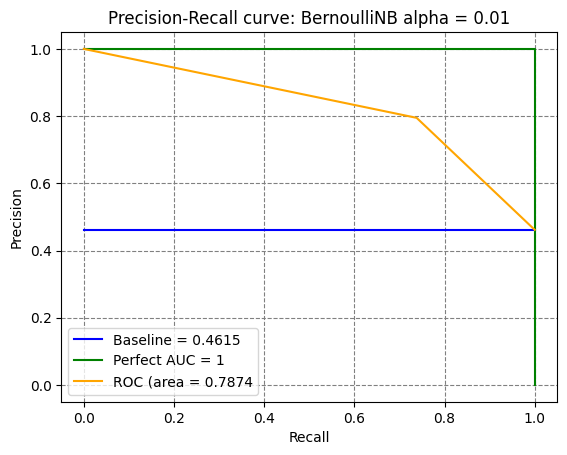

This is the alpha = 0.05 run.
Getting metrics...
ROC AUC score:  0.7874149659863946


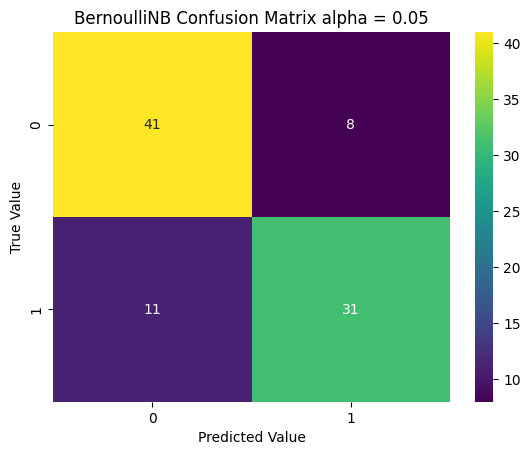

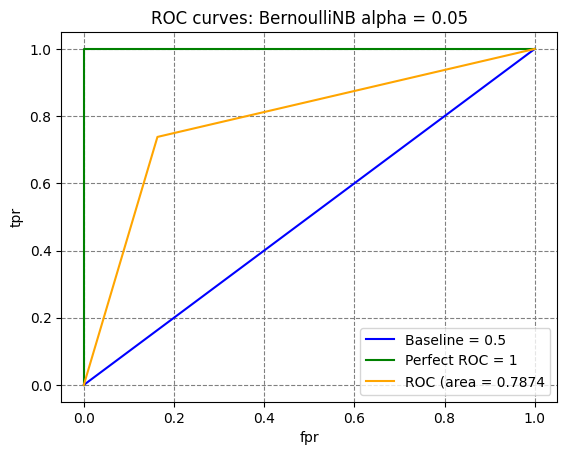

AUC:  0.7874149659863946


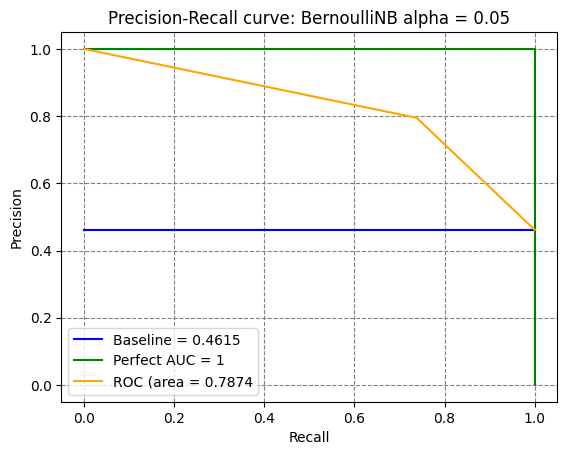

This is the alpha = 0.00001 run.
Getting metrics...
ROC AUC score:  0.7874149659863946


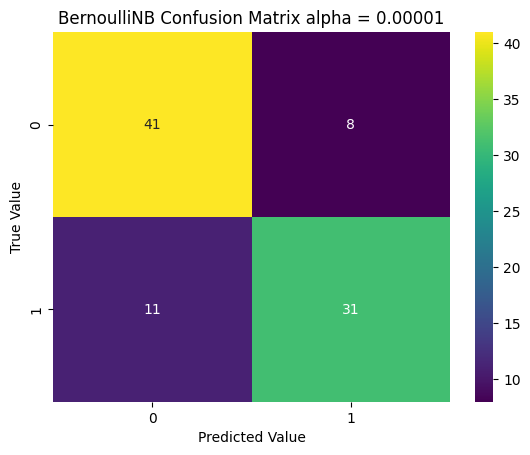

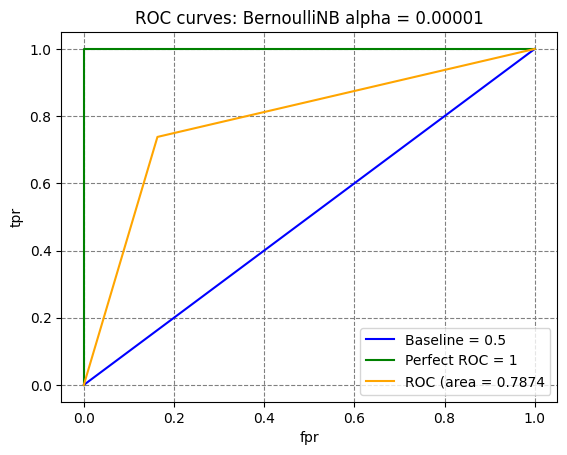

AUC:  0.7874149659863946


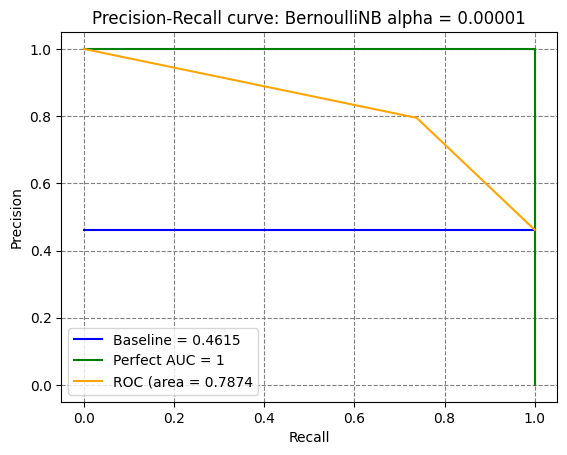

In [496]:
# Run model and get predictions

for laplace, alpha in alphasNB.items():
    print("This is the " + laplace + " run.")
    bernNB = BernoulliNB(alpha=alpha)
    bernNB.fit(X_train_bernNB, y_train)
    yhat_bernNB = bernNB.predict(X_test_bernNB)

    # Get metrics
    print('Getting metrics...')
    full_metrics_table = pd.DataFrame(classification_report(y_test, yhat_bernNB, output_dict=True)).reset_index().rename(columns={'index':'metrics'})

    metrics_totals = full_metrics_table[['metrics','macro avg','weighted avg']]
    metrics_totals.insert(loc=0, column='model_type', value='BernoulliNB_' + laplace)


    metrics_by_target_level = full_metrics_table.iloc[:, :-3]
    metrics_by_target_level.insert(loc=0, column='model_type', value='BernoulliNB_' + laplace)

    accuracy = round(full_metrics_table['accuracy'].max(), 4)
    area = round(roc_auc_score(y_test, yhat_bernNB), 4)
    
    # Get confusion matrix
    cm = confusion_matrix(y_test, yhat_bernNB)
    
    plot_dict['cm_'+ str(plot_count)] = plot_confusion_matrix(cm, title='BernoulliNB Confusion Matrix '+laplace)

    plot_dict['roc_'+ str(plot_count)] = plot_roc_curve(y_test, yhat_bernNB, model_version='BernoulliNB '+laplace)

    plot_dict['auc_' + str(plot_count)] = plot_auc_curve(y_test, yhat_bernNB, cm, model_version='BernoulliNB '+laplace)
    
    plot_count += 1

    models_accuracy_scores.loc[len(models_accuracy_scores.index)] = ['BernoulliNB', alpha, accuracy]
    metrics_totals_summary = pd.concat([metrics_totals_summary, metrics_totals])
    metrics_by_target_level_summary = pd.concat([metrics_by_target_level_summary, metrics_by_target_level])
    area_under_curves.loc[len(area_under_curves.index)] = ['BernoulliNB', alpha, area]


### Run GaussianNB

In [497]:
# Create the GaussianNB and LinearReg datasets with standardized vars and encoded vars
# We will exclude the categorical variable derived from continuous variables for this
included_num_vars = binary_cat + encoded_var_list  + list(standardized_df.columns) + ['ca_miss_ind']

# To update after reviewing results
# exclude_num_vars = [i for i in included_num_vars if '_category' in i] + encoded_var_list 
exclude_num_vars = []

X_train_gaussNB = X_train[[i for i in included_num_vars if i not in exclude_num_vars]]
X_test_gaussNB = X_test[[i for i in included_num_vars if i not in exclude_num_vars]]

print(X_train_gaussNB.columns, X_train_gaussNB.shape)
X_train_gaussNB.head()

Index(['sex', 'fbs', 'exang', 'trestbps_category', 'cp=1', 'cp=2', 'cp=3',
       'cp=4', 'restecg=0', 'restecg=1', 'restecg=2', 'slope=1', 'slope=2',
       'slope=3', 'thal=-1.0', 'thal=3.0', 'thal=6.0', 'thal=7.0',
       'age_category=Middle adulthood', 'age_category=Young adulthood',
       'age_category=Young old age', 'chol_category=Borderline high',
       'chol_category=High', 'chol_category=Normal',
       'oldpeak_category=[0.0, 0.5)', 'oldpeak_category=[0.5, 0.6)',
       'oldpeak_category=[0.6, 0.7)', 'oldpeak_category=[0.8, 0.9)',
       'oldpeak_category=[0.9, 1.0)', 'oldpeak_category=nan',
       'thalach_category=[71.0, 115.0)', 'thalach_category=[115.0, 126.0)',
       'thalach_category=[126.0, 142.0)', 'thalach_category=[142.0, 146.4)',
       'thalach_category=[146.4, 154.0)', 'thalach_category=[154.0, 159.6)',
       'thalach_category=[159.6, 163.0)', 'thalach_category=[163.0, 169.0)',
       'thalach_category=[169.0, 174.0)', 'thalach_category=[174.0, 202.0)',
   

,sex,fbs,exang,trestbps_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan,age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std,ca_miss_ind
0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.409140,-1.755970,-0.485687,-0.278951,0.155178,-0.685920,0
1,1,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.289004,0.132857,-0.912541,0.374263,-0.208332,0.424119,0
2,1,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873429,1.577254,0.469651,-1.628927,1.700094,0.424119,0
3,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.730626,-1.200432,-1.603636,-1.541832,0.882197,-0.685920,0
4,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.551942,2.355007,0.063124,-0.278951,-0.935352,-0.685920,0


Getting metrics...
ROC AUC score:  0.6547619047619048


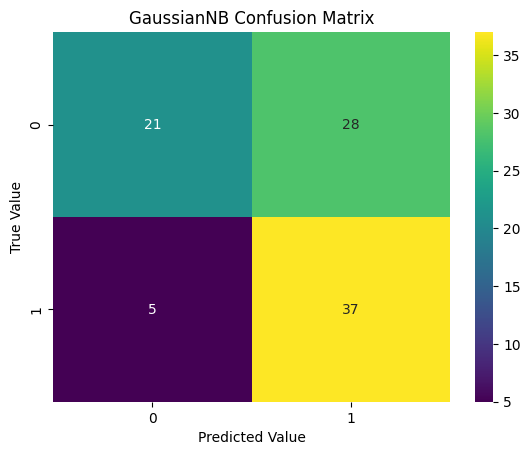

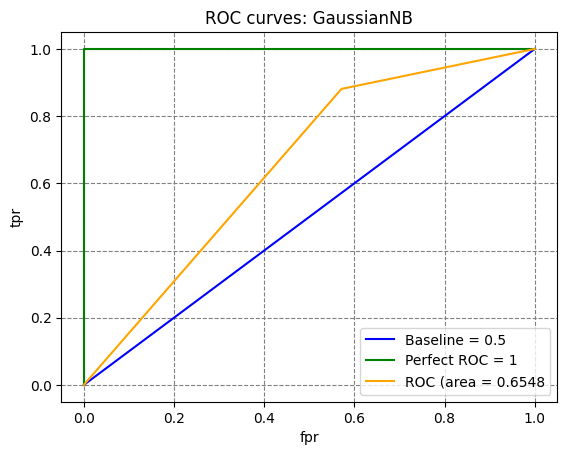

AUC:  0.6547619047619048


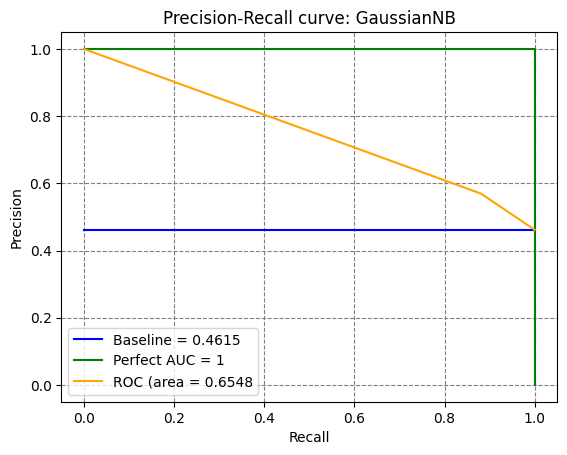

In [498]:
# Run model and get predictions

gaussNB = GaussianNB()
gaussNB.fit(X_train_gaussNB, y_train)
yhat_gaussNB = gaussNB.predict(X_test_gaussNB)

# Get metrics
print('Getting metrics...')
full_metrics_table = pd.DataFrame(classification_report(y_test, yhat_gaussNB, output_dict=True)).reset_index().rename(columns={'index':'metrics'})

metrics_totals = full_metrics_table[['metrics','macro avg','weighted avg']]
metrics_totals.insert(loc=0, column='model_type', value='GaussianNB')


metrics_by_target_level = full_metrics_table.iloc[:, :-3]
metrics_by_target_level.insert(loc=0, column='model_type', value='GaussianNB')

accuracy = round(full_metrics_table['accuracy'].max(), 4)
area = round(roc_auc_score(y_test, yhat_gaussNB), 4)


# Get confusion matrix
cm = confusion_matrix(y_test, yhat_gaussNB)

plot_dict['cm_'+ str(plot_count)] = plot_confusion_matrix(cm, title='GaussianNB Confusion Matrix')

plot_dict['roc_'+ str(plot_count)] = plot_roc_curve(y_test, yhat_gaussNB, model_version='GaussianNB')

plot_dict['auc_' +  str(plot_count)] = plot_auc_curve(y_test, yhat_gaussNB, cm, model_version='GaussianNB')

plot_count += 1

models_accuracy_scores.loc[len(models_accuracy_scores.index)] = ['GaussianNB', 'n/a', accuracy]
metrics_totals_summary = pd.concat([metrics_totals_summary, metrics_totals])
metrics_by_target_level_summary = pd.concat([metrics_by_target_level_summary, metrics_by_target_level])
area_under_curves.loc[len(area_under_curves.index)] = ['GaussianNB', 'n/a', area]

## b. Linear Regression

We will test the linear regression model on the dataset and extract key insights for best modle selection.

In [499]:
# Create the Linear Regression X datasets with standardized vars and encoded vars ( same as gaussian )
# We will exclude the categorical variable derived from continuous variables for this

X_train_LR = X_train[[i for i in included_num_vars if i not in exclude_num_vars]]
X_test_LR = X_test[[i for i in included_num_vars if i not in exclude_num_vars]]

print(X_train_LR.columns, X_train_LR.shape)
X_train_LR.head()

Index(['sex', 'fbs', 'exang', 'trestbps_category', 'cp=1', 'cp=2', 'cp=3',
       'cp=4', 'restecg=0', 'restecg=1', 'restecg=2', 'slope=1', 'slope=2',
       'slope=3', 'thal=-1.0', 'thal=3.0', 'thal=6.0', 'thal=7.0',
       'age_category=Middle adulthood', 'age_category=Young adulthood',
       'age_category=Young old age', 'chol_category=Borderline high',
       'chol_category=High', 'chol_category=Normal',
       'oldpeak_category=[0.0, 0.5)', 'oldpeak_category=[0.5, 0.6)',
       'oldpeak_category=[0.6, 0.7)', 'oldpeak_category=[0.8, 0.9)',
       'oldpeak_category=[0.9, 1.0)', 'oldpeak_category=nan',
       'thalach_category=[71.0, 115.0)', 'thalach_category=[115.0, 126.0)',
       'thalach_category=[126.0, 142.0)', 'thalach_category=[142.0, 146.4)',
       'thalach_category=[146.4, 154.0)', 'thalach_category=[154.0, 159.6)',
       'thalach_category=[159.6, 163.0)', 'thalach_category=[163.0, 169.0)',
       'thalach_category=[169.0, 174.0)', 'thalach_category=[174.0, 202.0)',
   

,sex,fbs,exang,trestbps_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan,"oldpeak_category=[0.0, 0.5)","oldpeak_category=[0.5, 0.6)","oldpeak_category=[0.6, 0.7)","oldpeak_category=[0.8, 0.9)","oldpeak_category=[0.9, 1.0)",oldpeak_category=nan,"thalach_category=[71.0, 115.0)","thalach_category=[115.0, 126.0)","thalach_category=[126.0, 142.0)","thalach_category=[142.0, 146.4)","thalach_category=[146.4, 154.0)","thalach_category=[154.0, 159.6)","thalach_category=[159.6, 163.0)","thalach_category=[163.0, 169.0)","thalach_category=[169.0, 174.0)","thalach_category=[174.0, 202.0)",thalach_category=nan,age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std,ca_miss_ind
0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.409140,-1.755970,-0.485687,-0.278951,0.155178,-0.685920,0
1,1,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.289004,0.132857,-0.912541,0.374263,-0.208332,0.424119,0
2,1,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873429,1.577254,0.469651,-1.628927,1.700094,0.424119,0
3,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.730626,-1.200432,-1.603636,-1.541832,0.882197,-0.685920,0
4,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.551942,2.355007,0.063124,-0.278951,-0.935352,-0.685920,0


This is the Regular LR run.
Getting metrics...
ROC AUC score:  0.8989310009718173


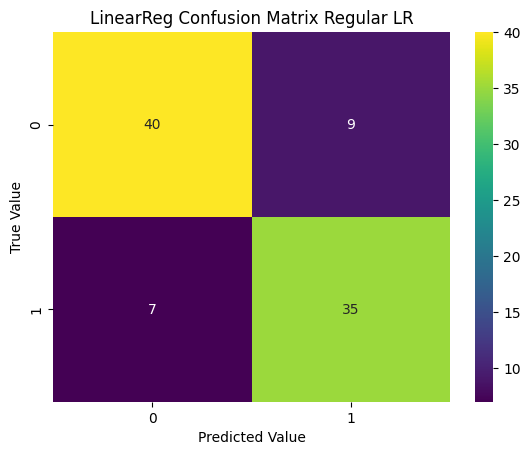

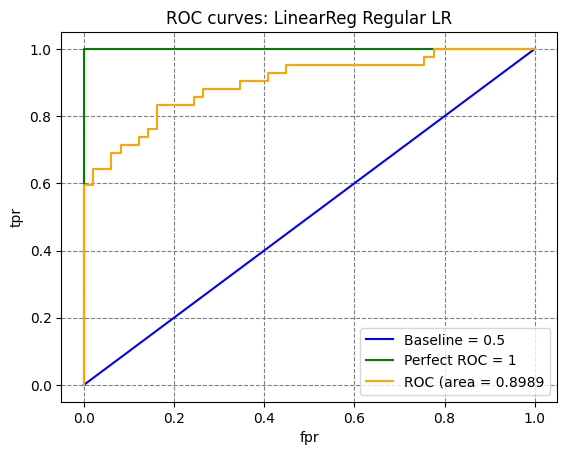

AUC:  0.8989310009718173


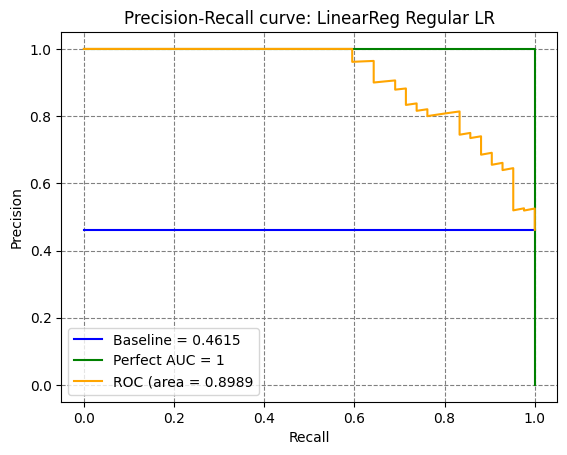

This is the Lasso run.
Getting metrics...
ROC AUC score:  0.5


/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

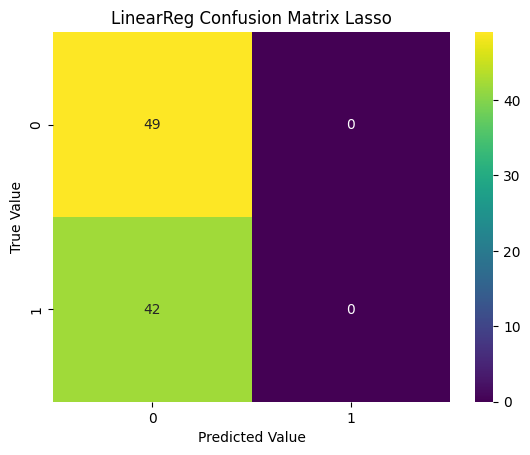

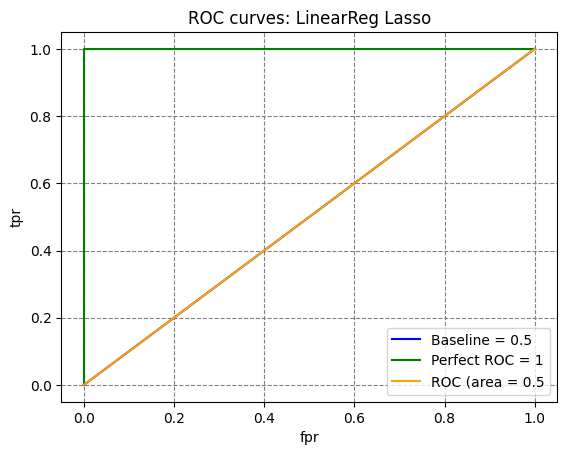

AUC:  0.5


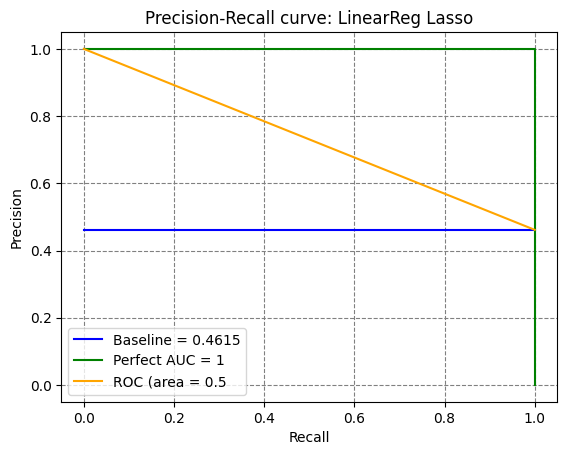

This is the Ridge run.
Getting metrics...
ROC AUC score:  0.9023323615160349


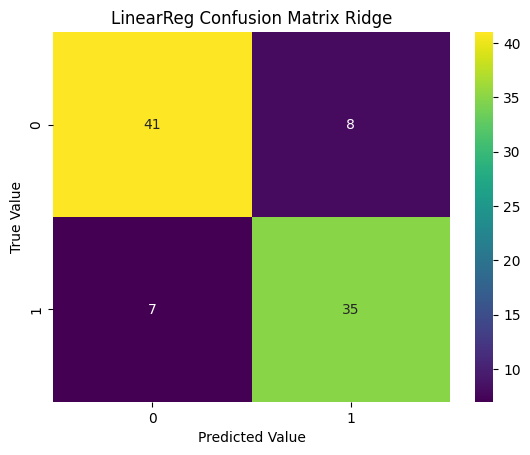

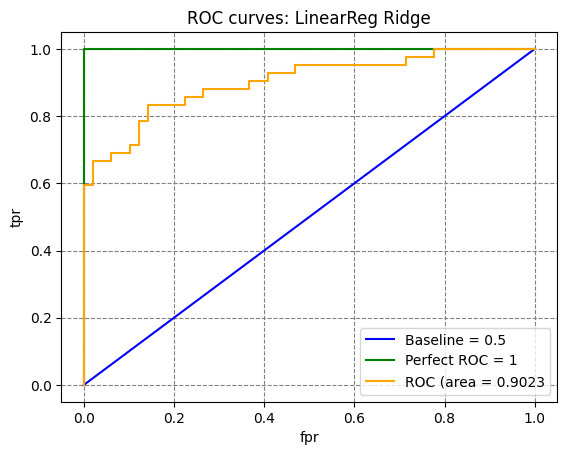

AUC:  0.9023323615160349


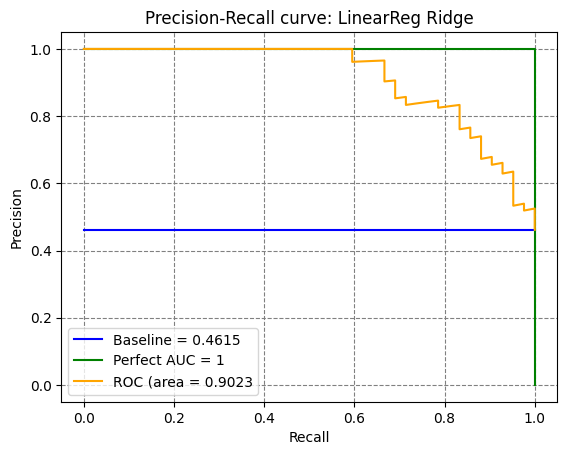

In [500]:
for penalization, alpha in alphasLR.items():
    print("This is the " + penalization + " run.")
    if penalization == "Lasso":
        LR = Lasso()
    elif penalization == "Ridge":
        LR = Ridge()
    else:
        LR = LinearRegression()

    LR.fit(X_train_LR, y_train)
    yhat_LR = LR.predict(X_test_LR)
    yhat_LR_class = np.round(yhat_LR).astype(int)

    # Get metrics
    print('Getting metrics...')

    # Error metrics
    mse = mean_squared_error(y_test, yhat_LR)
    mae = mean_absolute_error(y_test, yhat_LR)
    r2 = r2_score(y_test, yhat_LR)

    error_metrics.loc[len(error_metrics.index)] = ['LinearReg_' + penalization,mse, mae, r2]

    # Retrieve coeff table
    coeff_table = pd.DataFrame({'Feature':LR.feature_names_in_, 'Coefficient': LR.coef_})
    coeff_table.loc[len(coeff_table.index)] = ['Intercept', LR.intercept_]
    coeff_table.insert(loc=0, column='model_type', value='LinearReg_' + penalization)

    coeff_table_summary = pd.concat([coeff_table_summary, coeff_table])

    # Use 0.5 threshold for comparison with classifiers
    yhat_LR_class = (yhat_LR >= 0.5).astype(int)

    full_metrics_table = pd.DataFrame(classification_report(y_test, yhat_LR_class, output_dict=True)).reset_index().rename(columns={'index':'metrics'})

    metrics_totals = full_metrics_table[['metrics','macro avg','weighted avg']]
    metrics_totals.insert(loc=0, column='model_type', value='LinearReg_' + penalization)


    metrics_by_target_level = full_metrics_table.iloc[:, :-3]
    metrics_by_target_level.insert(loc=0, column='model_type', value='LinearReg_' + penalization)

    accuracy = round(full_metrics_table['accuracy'].max(), 4)
    area = round(roc_auc_score(y_test, yhat_LR), 4)


    # Get confusion matrix
    cm = confusion_matrix(y_test, yhat_LR_class)

    plot_dict['cm_'+ str(plot_count)] = plot_confusion_matrix(cm, title='LinearReg Confusion Matrix '+penalization)

    plot_dict['roc_'+ str(plot_count)] = plot_roc_curve(y_test, yhat_LR, model_version='LinearReg '+penalization)

    plot_dict['auc_' +  str(plot_count)] = plot_auc_curve(y_test, yhat_LR, cm, model_version='LinearReg '+penalization)

    plot_count += 1

    models_accuracy_scores.loc[len(models_accuracy_scores.index)] = ['LinearReg', alpha, accuracy]
    metrics_totals_summary = pd.concat([metrics_totals_summary, metrics_totals])
    metrics_by_target_level_summary = pd.concat([metrics_by_target_level_summary, metrics_by_target_level])
    area_under_curves.loc[len(area_under_curves.index)] = ['LinearReg', alpha, area]

In [501]:
models_accuracy_scores

,model,alpha,accuracy
0,BernoulliNB,1.0,0.8132
1,BernoulliNB,0.01,0.7912
2,BernoulliNB,0.05,0.7912
3,BernoulliNB,0.00001,0.7912
4,GaussianNB,n/a,0.6374
5,LinearReg,n/a,0.8242
6,LinearReg,0,0.5385
7,LinearReg,1,0.8352


In [502]:
metrics_totals_summary

,model_type,metrics,macro avg,weighted avg
0,BernoulliNB_alpha = 1,precision,0.812439,0.813021
1,BernoulliNB_alpha = 1,recall,0.811224,0.813187
2,BernoulliNB_alpha = 1,f1-score,0.811732,0.813005
3,BernoulliNB_alpha = 1,support,91.000000,91.000000
0,BernoulliNB_alpha = 0.01,precision,0.791667,0.791420
1,BernoulliNB_alpha = 0.01,recall,0.787415,0.791209
2,BernoulliNB_alpha = 0.01,f1-score,0.788657,0.790443
3,BernoulliNB_alpha = 0.01,support,91.000000,91.000000
0,BernoulliNB_alpha = 0.05,precision,0.791667,0.791420
1,BernoulliNB_alpha = 0.05,recall,0.787415,0.791209


In [503]:
metrics_by_target_level_summary

,model_type,metrics,0,1
0,BernoulliNB_alpha = 1,precision,0.820000,0.804878
1,BernoulliNB_alpha = 1,recall,0.836735,0.785714
2,BernoulliNB_alpha = 1,f1-score,0.828283,0.795181
3,BernoulliNB_alpha = 1,support,49.000000,42.000000
0,BernoulliNB_alpha = 0.01,precision,0.788462,0.794872
1,BernoulliNB_alpha = 0.01,recall,0.836735,0.738095
2,BernoulliNB_alpha = 0.01,f1-score,0.811881,0.765432
3,BernoulliNB_alpha = 0.01,support,49.000000,42.000000
0,BernoulliNB_alpha = 0.05,precision,0.788462,0.794872
1,BernoulliNB_alpha = 0.05,recall,0.836735,0.738095


In [504]:
area_under_curves

,model,alpha,roc/auc
0,BernoulliNB,1.0,0.8112
1,BernoulliNB,0.01,0.7874
2,BernoulliNB,0.05,0.7874
3,BernoulliNB,0.00001,0.7874
4,GaussianNB,n/a,0.6548
5,LinearReg,n/a,0.8989
6,LinearReg,0,0.5000
7,LinearReg,1,0.9023


In [505]:
error_metrics

,model,MSE,MAE,R2
0,LinearReg_Regular LR,0.132318,0.285822,0.467576
1,LinearReg_Lasso,0.248537,0.496734,-0.000064
2,LinearReg_Ridge,0.128625,0.280888,0.482436


In [506]:
coeff_table_summary

,model_type,Feature,Coefficient
0,LinearReg_Regular LR,sex,0.230262
1,LinearReg_Regular LR,fbs,-0.041581
2,LinearReg_Regular LR,exang,0.087103
3,LinearReg_Regular LR,trestbps_category,-0.002958
4,LinearReg_Regular LR,cp=1,0.057060
...,...,...,...
61,LinearReg_Ridge,thalach_std,-0.054593
62,LinearReg_Ridge,oldpeak_std,0.010935
63,LinearReg_Ridge,ca_std,0.108606
64,LinearReg_Ridge,ca_miss_ind,-0.185528


# Model Evaluation

In [507]:
results_summary['accuracy_scores'] = models_accuracy_scores
results_summary['metrics_summary'] = metrics_totals_summary
results_summary['target_level_metrics'] = metrics_by_target_level_summary
results_summary['area_under_curves'] = area_under_curves
results_summary['error_metrics'] = error_metrics
results_summary['coefficients'] = coeff_table_summary

In [508]:
# Output results to excel for easier review

with pd.ExcelWriter(folder_path+result_filename) as writer:
    for sheet_name, result_df in results_summary.items():
        result_df.to_excel(writer, sheet_name = sheet_name, index=False)

    workbook = writer.book
    worksheet_cm = writer.sheets['metrics_summary']
    worksheet_roc_auc = writer.sheets['area_under_curves']

    row = 0

    # Add confusion matrices
    for plot_name, fig in plot_dict.items():
        if 'cm_' in plot_name:
            # Set the figure size
            fig.set_size_inches(8, 6)
            # Save the figure to a temporary file
            img_path = plot_path + plot_name + '.png'
            fig.savefig(img_path, bbox_inches='tight')
            # Insert the image into the worksheet
            worksheet_cm.insert_image(row, 6, img_path)
            plt.close(fig)  # Close the figure to free memory
            if 'cm_1' == plot_name:
                row == 0
            else:
                row += 30
                
            
        else:
            # Set the figure size
            fig.set_size_inches(8, 6)
            # Save the figure to a temporary file
            img_path = plot_path + plot_name + '.png'
            fig.savefig(img_path, bbox_inches='tight')
            # Insert the image into the worksheet
            worksheet_roc_auc.insert_image(row, 4, img_path)
            plt.close(fig)  # Close the figure to free memory
            if 'roc_1' == plot_name:
                row == 0
            else:
                row += 30

writer.close()

/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/xlsxwriter/workbook.py:404: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
